# UBS_lauzhack - Entity resolution model

## 1. Pre-processing

Observed the given dataset and apply the proper transformations to the data in order to better anlyse it and create the model.

In [95]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
import warnings


InteractiveShell.ast_node_interactivity = "all"
#pd.set_option('precision', 3)
display.precision = 3
sns.set()
warnings.filterwarnings('ignore')

# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
#from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox



In [96]:
# Read the CSV files from the 'data' subfolder
#account_booking_df = pd.read_csv('data/account_booking_train.csv')
#external_parties_df = pd.read_csv('data/external_parties_train.csv')

account_booking_df = pd.read_csv('../account_booking_test.csv')
external_parties_df = pd.read_csv('../external_parties_test.csv')

In [97]:
# Combine the tables with merge using 
combined_data = pd.merge(account_booking_df, external_parties_df, on='transaction_reference_id', how='inner')

In [98]:
#Null count of each variables to know which ones are more relevant to analyze
combined_data.isnull().sum()

transaction_reference_id              0
debit_credit_indicator                0
account_id                            0
transaction_amount                    0
transaction_currency                  0
transaction_date                      0
party_role                            0
party_info_unstructured               0
parsed_name                           0
parsed_address_street_name       105595
parsed_address_street_number     407501
parsed_address_unit             1481672
parsed_address_postal_code       461156
parsed_address_city              152702
parsed_address_state            1222710
parsed_address_country           832475
party_iban                       444527
party_phone                      666700
dtype: int64

In [99]:
# Drop the columns that have more than 50% of missing values and irrelevant information

## External parties data

irrelevant_cols_external = ['party_info_unstructured', 'parsed_address_unit', 'parsed_address_state', 'parsed_address_country']
external_parties_df.drop(columns=irrelevant_cols_external, inplace=True, errors='ignore')

## Accounts booking data
duplicate_ids = account_booking_df[account_booking_df.duplicated(subset='transaction_reference_id', keep=False)]
account_booking_df = account_booking_df[~account_booking_df['transaction_reference_id'].isin(duplicate_ids['transaction_reference_id'])]

irrelevant_cols_booking = ['debit_credit_indicator']
account_booking_df.drop(columns=irrelevant_cols_booking, inplace=True, errors='ignore')

# Merge the two dataframes

merged_df = pd.merge(external_parties_df, account_booking_df, on='transaction_reference_id', how='inner')

merged_df.to_csv('merged_data_cleaned.csv', index=False)

In [100]:

honorifics = ['Mr. ', 'Ms. ', 'Mrs. ', 'Miss ', 'Dr. ', 'Prof. ', 'Rev. ', 'Hon. ', 'mr. ', 'ms. ', 'mrs. ', 'miss ', 'dr. ', 'prof. ', 'rev. ', 'hon. ']
for honorific in honorifics:
    merged_df['parsed_name'] = merged_df['parsed_name'].str.replace(honorific, '')


def delete_duplicates(name):
    def remove_duplicates(text):
        words = text.split()
        seen = set()
        result = []
        for word in words:
            if word.lower() not in seen:
                seen.add(word.lower())
                result.append(word)
        return ' '.join(result)
    
    name['parsed_name'] = name['parsed_name'].apply(remove_duplicates)
    return name

merged_df = delete_duplicates(merged_df)


In [101]:
from metaphone import doublemetaphone

def apply_metaphone(value):
    if isinstance(value, list) or isinstance(value, np.ndarray):  
        return np.nan  
    if pd.isna(value) or not isinstance(value, str):  
        return np.nan
    return doublemetaphone(value.strip().lower())[0] 

def split_and_metaphone(full_name):
    """
    Divide un nombre completo en sus partes (palabras), aplica Metaphone a cada parte,
    y las junta nuevamente con espacios.
    """
    if pd.isna(full_name) or not isinstance(full_name, str):  
        return np.nan

    parts = full_name.strip().split()

    return ' '.join(apply_metaphone(part) for part in parts)

merged_df['parsed_name'] = merged_df['parsed_name'].apply(split_and_metaphone)

print(merged_df['parsed_name'].head())


0                  0RS HMFR
1                    HL TTL
2               MKFRLN TKNK
3                    JM KPR
4    FRNNTSS FRST ANT KNSLS
Name: parsed_name, dtype: object


In [102]:
merged_df['parsed_address_street_name'] = merged_df['parsed_address_street_name'].apply(split_and_metaphone)

print(merged_df['parsed_address_street_name'].head())

merged_df.to_csv('merged_data_cleaned.csv', index=False)

0             JN PRKS
1    TK LS ALNTS TNLS
2            JSF ANLT
3             ASTN LT
4      TMS KRSNT APTT
Name: parsed_address_street_name, dtype: object


In [103]:
def categorize_transaction_amount(amount):
    if amount < 1000:
        return 1
    elif amount < 5000:
        return 2
    else:
        return 3

merged_df['transaction_date'] = pd.to_datetime(merged_df['transaction_date'], errors='coerce')

# Extract month and day of the week from transaction_date
merged_df['transaction_month'] = merged_df['transaction_date'].dt.month
merged_df['transaction_day_of_week'] = merged_df['transaction_date'].dt.dayofweek
merged_df['transaction_category'] = merged_df['transaction_amount'].apply(categorize_transaction_amount)

# Normalize the transaction_amount, transaction_month, and transaction_day_of_week columns to a range of 0 to 1
scaler = preprocessing.MinMaxScaler()

merged_df[['transaction_category', 'transaction_month', 'transaction_day_of_week']] = scaler.fit_transform(
    merged_df[['transaction_category', 'transaction_month', 'transaction_day_of_week']])

# Drop the original transaction_date column
columns_to_drop = ['transaction_date', 'party_info_unstructured', 'parsed_address_unit', 'parsed_address_state', 'parsed_address_country', 'parsed_address_street_number', 'party_iban', 'party_phone', 'debit_credit_indicator', 'transaction_currency',]
merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], inplace=True)

print(merged_df.columns)

Index(['transaction_reference_id', 'party_role', 'parsed_name',
       'parsed_address_street_name', 'parsed_address_postal_code',
       'parsed_address_city', 'account_id', 'transaction_amount',
       'transaction_month', 'transaction_day_of_week', 'transaction_category'],
      dtype='object')


In [104]:
def create_block_key(value, prefix_length=5):
    if pd.isna(value):  # Maneja valores faltantes
        return 'MISSING'
    return value[:prefix_length].lower()

# Aplica el bloqueo en la columna deseada
merged_df['block'] = merged_df['parsed_name'].apply(create_block_key, prefix_length=3)

def create_combined_block(row):
    # Combina prefijos de varias columnas
    name_key = create_block_key(row['parsed_name'], prefix_length=3)
    address_key = create_block_key(row['parsed_address_street_name'], prefix_length=3)
    return f"{name_key}_{address_key}"

merged_df['block'] = merged_df.apply(create_combined_block, axis=1)
blocks = merged_df.groupby('block')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix


def calculate_text_similarity(df, col1, col2):
    # Convert columns to strings and fill NaN values with empty strings    
    vectorizer = TfidfVectorizer()
    tfidf_matrix1 = vectorizer.fit_transform(df[col1])
    tfidf_matrix2 = vectorizer.transform(df[col2])
    
    # Calculamos la similitud del coseno
    similarity_matrix = cosine_similarity(tfidf_matrix1, tfidf_matrix2)
    return csr_matrix(similarity_matrix)

def calculate_date_and_amount_similarity(df, col1, col2):
    # Convert columns to numerical values if they are not already
    df[col1] = pd.to_numeric(df[col1], errors='coerce')
    df[col2] = pd.to_numeric(df[col2], errors='coerce')
    
    # Fill NaN values with a large number to indicate dissimilarity
    df[col1].fillna(9999, inplace=True)
    df[col2].fillna(9999, inplace=True)
    
    # Calculamos la diferencia absoluta entre los valores de las columnas
    diff = np.abs(df[col1].values.reshape(-1, 1) - df[col2].values.reshape(1, -1))
    # Normalizamos la diferencia para obtener similitud [0, 1]
    similarity = 1 / (1 + diff)  # Cuanto menor la diferencia, mayor la similitud
    return csr_matrix(similarity)

def calculate_similarity(df):
    text_similarity = calculate_text_similarity(df, 'parsed_name', 'parsed_address_street_name')
    amount_similarity = calculate_date_and_amount_similarity(df, 'transaction_category', 'transaction_category')
    month_similarity = calculate_date_and_amount_similarity(df, 'transaction_month', 'transaction_month')
    day_similarity = calculate_date_and_amount_similarity(df, 'transaction_day_of_week', 'transaction_day_of_week')
    
    # Combine all similarities (this is just an example, adjust as needed)
    combined_similarity = (0.4 * text_similarity + 0.2 * amount_similarity + 0.2 * month_similarity + 0.2 * day_similarity)
    return csr_matrix(combined_similarity)

results = []
# Main code
for block_name, block_data in blocks:
    print(f"Processing block: {block_name}")
    
    if len(block_data) < 2:
        block_data['external_id'] = range(len(results), len(results) + len(block_data))
        results.append(block_data)
        continue

    # Similaridad para 'parsed_name' y 'parsed_address_street_name'
    name_and_address_similarity = calculate_similarity(block_data)

    # Asegúrate de que los valores de la matriz de similitud estén en el rango [0, 1]
    name_and_address_similarity = np.clip(name_and_address_similarity, 0, 1)

    # Convertimos la matriz de similitud en distancias
    distance_matrix = 1 - name_and_address_similarity

    # Debug: Check shapes
    print(f"distance_matrix shape: {distance_matrix.shape}")
    print(f"block_data shape: {block_data.shape}")

    # Aplicamos DBSCAN
    db = DBSCAN(eps=0.3, min_samples=2, metric='precomputed')
    clusters = db.fit_predict(distance_matrix)

    # Debug: Check clusters length
    print(f"clusters length: {len(clusters)}")
    print(f"block_data length: {len(block_data)}")

    # Ensure the lengths match before assignment
    if len(clusters) == len(block_data):
        # Asignamos clusters como 'external_id'
        block_data['external_id'] = clusters + len(results)  # Evita conflictos entre bloques
        results.append(block_data)
    else:
        print("Error: Length of clusters does not match length of block_data")



# Similaridad para 'parsed_name' y 'parsed_address_street_name'
name_and_address_similarity = calculate_similarity(block_data)

# Asegúrate de que los valores de la matriz de similitud estén en el rango [0, 1]
name_and_address_similarity = np.clip(name_and_address_similarity, 0, 1)

# Convertimos la matriz de similitud en distancias
distance_matrix = 1 - name_and_address_similarity


final_df = pd.concat(results, ignore_index=True)
cluster_sizes = final_df['external_id'].value_counts()
valid_clusters = cluster_sizes[cluster_sizes > 1].index

# Filtramos las filas que pertenecen a esos clusters
filtered_df = final_df[final_df['external_id'].isin(valid_clusters)]
filtered_df = filtered_df[['external_id', 'transaction_reference_id']]

Processing block:   a_ast
Processing block:   a_mts
Processing block:  0r_ kr
Processing block:  0r_krs
Processing block:  0r_lr 
Processing block:  a _MISSING
Processing block:  a _a a
Processing block:  a _jrm
Processing block:  a _krs
Processing block:  a _ls 
Processing block:  a _prt
Processing block:  a _rnt
Processing block:  a _sm0
Processing block:  a _tkr
Processing block:  a0_kkr
Processing block:  a0_mnr
Processing block:  a_frm
Processing block:  a_frn


ValueError: empty vocabulary; perhaps the documents only contain stop words

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='external_id'>

Text(0.5, 1.0, 'Distribución de Clusters')

Text(0.5, 0, 'Cluster ID')

Text(0, 0.5, 'Tamaño del Cluster')

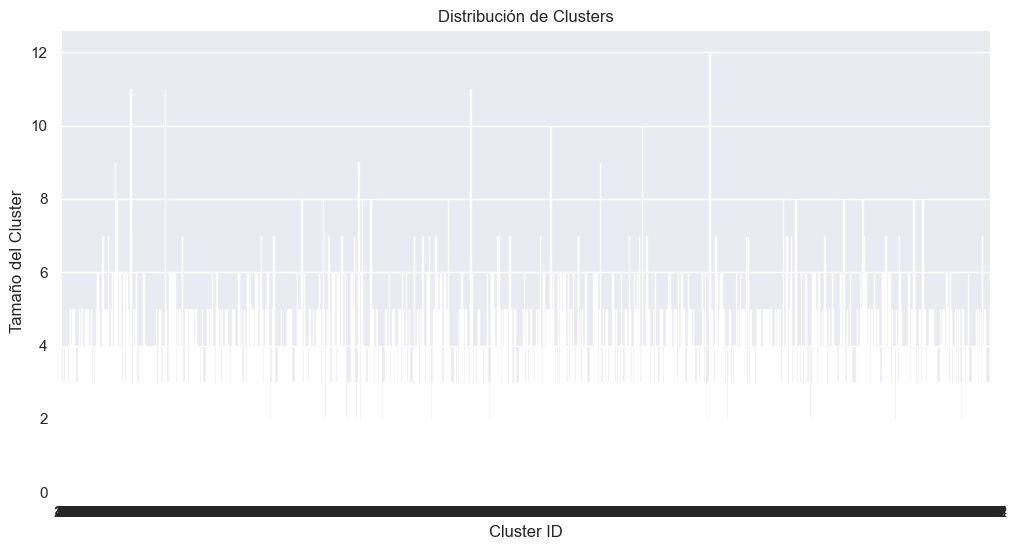

In [ ]:
# Visualizar el tamaño de cada cluster
cluster_sizes = filtered_df['external_id'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
plt.title('Distribución de Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Tamaño del Cluster')
plt.show()


### 1.1 Pre-processing of the variable parsed_name

### 1.2 Phone pre-processing